In [108]:
import timeit

import numpy as np
import pandas as pd

from cppsort import cppsort

In [109]:
def random_data(size):
    return np.random.randint(size, size=size, dtype="int32")

First, let's time NumPy's `.sort()`

In [110]:
def format_time(dt):
    units = {"ns": 1e-9, "us": 1e-6, "ms": 1e-3, "s": 1.0}
    for name, u in units.items():
        if dt/u < 1000:
            return f"{dt/u} {name}"
    return f"{dt} sec"

In [111]:
def time_sort(size, sort_func):    
    repeat = 10
    dt = 0
    for i in range(repeat):
        data = random_data(size)
        start = timeit.default_timer()
        sort_func(data)
        end = timeit.default_timer()
        dt += (end - start)
    return (dt) / repeat

In [112]:
sizes = [100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]

In [113]:
numpy_times = pd.Series(
    [time_sort(s, lambda x: x.sort()) for s in sizes],
    index=sizes,
    name="NumPy"
)
numpy_times.map(format_time)

100          26.15833654999733 us
1000         99.97468441724777 us
10000       1.0788118466734886 ms
100000       5.617252830415964 ms
1000000      63.00150714814663 ms
10000000     738.6317477561533 ms
Name: NumPy, dtype: object

Serial cppsort:

In [114]:
%%writefile cppsort_serial.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort

def cppsort(int[:] x):
    sort(&x[0], &x[-1] + 1)
    

Overwriting cppsort_serial.pyx


In [115]:
!python setup.py build_ext --inplace

Compiling cppsort_serial.pyx because it changed.
[1/1] Cythonizing cppsort_serial.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/sort/cppsort_serial.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_serial' extension
gcc -pthread -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_serial.cpp -o build/temp.linux-x86_64-3.8/cppsort_serial.o -std=c++17
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
g++ -pthread -shared -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -L/home/ashwin/miniconda3/envs/cython-dev/lib -Wl,-r

In [116]:
from cppsort_serial import cppsort

cppsort_serial_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="cppsort_serial"
)
cppsort_serial_times.map(format_time)

100         12.619327753782272 us
1000         99.90176185965538 us
10000       1.0472103953361511 ms
100000       5.663973465561867 ms
1000000      63.61503358930349 ms
10000000     737.7866001799702 ms
Name: cppsort_serial, dtype: object

In [117]:
%%writefile cppsort_parallel.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort
from libcpp.execution cimport par

def cppsort(int[:] x):
    sort(par, &x[0], &x[-1] + 1)

Overwriting cppsort_parallel.pyx


In [118]:
!python setup.py build_ext --inplace

Compiling cppsort_parallel.pyx because it changed.
[1/1] Cythonizing cppsort_parallel.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/sort/cppsort_parallel.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_parallel' extension
gcc -pthread -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_parallel.cpp -o build/temp.linux-x86_64-3.8/cppsort_parallel.o -std=c++17
cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
g++ -pthread -shared -B /home/ashwin/miniconda3/envs/cython-dev/compiler_compat -L/home/ashwin/miniconda3/envs/cython-de

In [119]:
from cppsort_parallel import cppsort

cppsort_parallel_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="cppsort_parallel"
)
cppsort_parallel_times.map(format_time)

100         13.918243348598482 us
1000        126.41288340091705 us
10000       315.37339091300964 us
100000      1.5381880104541779 ms
1000000     11.493029817938805 ms
10000000    132.92472083121538 ms
Name: cppsort_parallel, dtype: object

In [120]:
%%writefile cppsort_stdpar.pyx

# distutils: language=c++

from libcpp.algorithm cimport sort, copy_n
from libcpp.execution cimport par
from libcpp.vector cimport vector

def cppsort(int[:] x):
    """
    Sort the elements of x "in-place" using std::sort
    """
    cdef vector[int] vec
    vec.resize(len(x))
    copy_n(&x[0], len(x), vec.begin())
    sort(par, vec.begin(), vec.end())
    copy_n(vec.begin(), len(x), &x[0])

Overwriting cppsort_stdpar.pyx


In [121]:
!CC=/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ python setup.py build_ext --inplace

Compiling cppsort_stdpar.pyx because it changed.
[1/1] Cythonizing cppsort_stdpar.pyx
/home/ashwin/workspace/github/cython/cython/Cython/Compiler/Main.py:344: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /home/ashwin/workspace/github/shwina/stdpar-cython/sort/cppsort_stdpar.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'cppsort_stdpar' extension
/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -fPIC -stdpar -gpu=nordc -std=c++17 -I/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/include-stdpar -I/home/ashwin/miniconda3/envs/cython-dev/include/python3.8 -c cppsort_stdpar.cpp -o build/temp.linux-x86_64-3.8/cppsort_stdpar.o -std=c++17
"cppsort_stdpar.cpp", line 18153: warning: variable "__pyx_lineno" was set but
          never used
    int __pyx_lineno = 0;
        ^

"cppsort_stdpar.cpp", line 18154: warning: variable "__pyx_filename" was set
      

/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/bin/nvc++ -shared -stdpar build/temp.linux-x86_64-3.8/cppsort_stdpar.o -L/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -Wl,-R/home/ashwin/tmp/hpc_sdk/Linux_x86_64/dev/compilers/lib -o build/lib.linux-x86_64-3.8/cppsort_stdpar.cpython-38-x86_64-linux-gnu.so
copying build/lib.linux-x86_64-3.8/cppsort.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_parallel.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_serial.cpython-38-x86_64-linux-gnu.so -> 
copying build/lib.linux-x86_64-3.8/cppsort_stdpar.cpython-38-x86_64-linux-gnu.so -> 


In [122]:
from cppsort_stdpar import cppsort

cppsort_stdpar_times = pd.Series(
    [time_sort(s, lambda x: cppsort(x)) for s in sizes],
    index=sizes,
    name="cppsort_stdpar"
)
cppsort_stdpar_times.map(format_time)

100          868.2208135724068 us
1000         446.1145028471947 us
10000        2.264292724430561 ms
100000      1.4940942637622356 ms
1000000      3.731072973459959 ms
10000000    31.147489976137877 ms
Name: cppsort_stdpar, dtype: object

In [123]:
numpy_times

100         0.000026
1000        0.000100
10000       0.001079
100000      0.005617
1000000     0.063002
10000000    0.738632
Name: NumPy, dtype: float64

In [124]:
all_times = pd.DataFrame([numpy_times, cppsort_serial_times, cppsort_parallel_times, cppsort_stdpar_times]).T
speedups = (1/all_times).multiply(numpy_times, axis=0)

In [125]:
speedups

,NumPy,cppsort_serial,cppsort_parallel,cppsort_stdpar
100,1.0,2.072879,1.879428,0.030129
1000,1.0,1.000730,0.790858,0.224101
10000,1.0,1.030177,3.420745,0.476445
100000,1.0,0.991751,3.651864,3.759638
1000000,1.0,0.990356,5.481714,16.885627
10000000,1.0,1.001146,5.556767,23.714005


<AxesSubplot:>

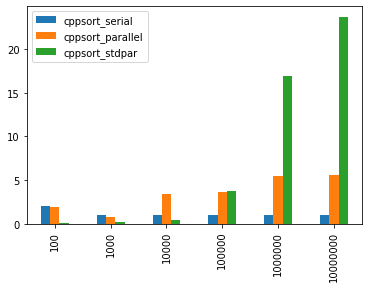

In [127]:
speedups.iloc[:, 1:].plot(kind="bar")